In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def pmppm(mass, ppm=4):
    return(mass*(1-ppm/1000000), mass*(1+ppm/1000000))

## Chromatogram extraction

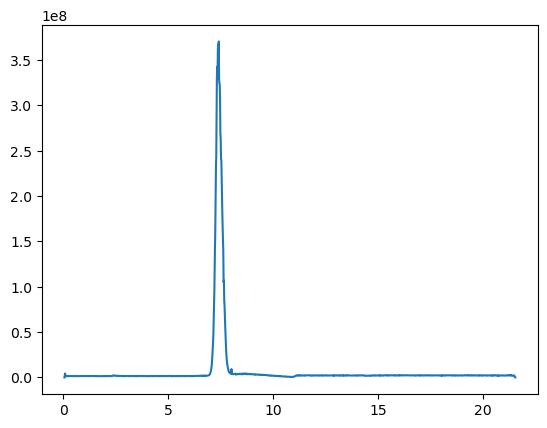

In [2]:
from pyteomics import mzml

def get_chrom_mzml_pyteomics(file, mz, ppm):
    mzmin, mzmax = pmppm(mz, ppm)

    scan_dfs = []
    for spectrum in mzml.MzML(file):
        rt_val = spectrum['scanList']['scan'][0]['scan start time']
        mz_vals=spectrum['m/z array']
        int_vals = spectrum['intensity array']

        bet_idxs = (spectrum["m/z array"]>mzmin) & (spectrum["m/z array"]<mzmax)
        if(sum(bet_idxs)>0):
            df_scan = pd.DataFrame({'mz':mz_vals[bet_idxs], 'int':int_vals[bet_idxs], 'rt':[rt_val]*sum(bet_idxs)})
            scan_dfs.append(df_scan)    
    return(pd.concat(scan_dfs, ignore_index=True))

chrom_data = get_chrom_mzml_pyteomics('demo_data/180205_Poo_TruePoo_Full1.mzML', 118.0865, 10)

plt.plot(chrom_data["rt"], chrom_data["int"])
plt.show()

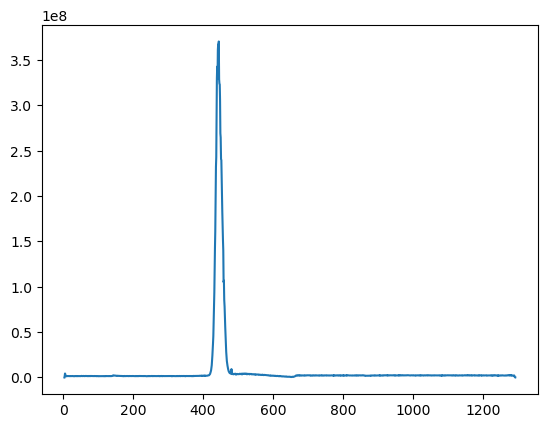

In [3]:
import pyopenms

def get_chrom_mzml_pyopenms(file, mz, ppm):
    exp = pyopenms.MSExperiment()
    pyopenms.MzMLFile().load(file, exp)
    mzmin, mzmax = pmppm(mz, ppm)
    
    scan_dfs = []
    for spectrum in exp:
        rt_val = spectrum.getRT()
        mz_vals, int_vals = spectrum.get_peaks()
        bet_idxs = (mz_vals>mzmin) & (mz_vals<mzmax)
    
        if(sum(bet_idxs)>0):
            df_scan = pd.DataFrame({'mz':mz_vals[bet_idxs], 'int':int_vals[bet_idxs], 'rt':[rt_val]*sum(bet_idxs)})
            scan_dfs.append(df_scan)    
    return(pd.concat(scan_dfs, ignore_index=True))

chrom_data = get_chrom_mzml_pyopenms("demo_data/180205_Poo_TruePoo_Full1.mzML", 118.0865, 10)

plt.plot(chrom_data["rt"], chrom_data["int"])
plt.show()

[Warning] Not index found and build_index_from_scratch is False
[Warning] Not index found and build_index_from_scratch is False


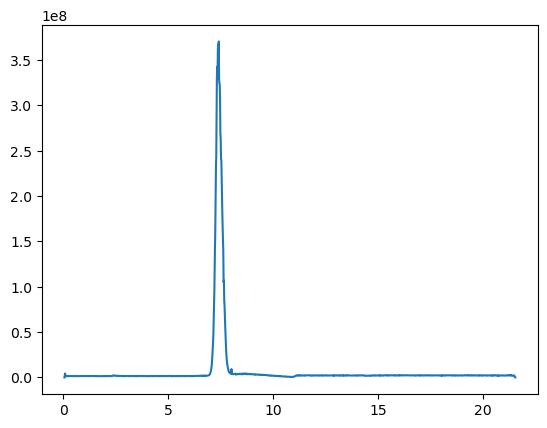

In [4]:
# Example available at https://github.com/pymzml/pymzML/blob/dev/example_scripts/extract_ion_chromatogram.py
# but does not show how to add a ppm tolerance
import pymzml

def get_chrom_mzml_pymzml(file, mz, ppm):
    run = pymzml.run.Reader(file)
    mzmin, mzmax = pmppm(mz, ppm)
    
    scan_dfs = []
    for spectrum in run:
        rt_val = spectrum.scan_time_in_minutes()
        mz_vals = spectrum.mz
        int_vals = spectrum.i
        bet_idxs = (mz_vals>mzmin) & (mz_vals<mzmax)
    
        if(sum(bet_idxs)>0):
            df_scan = pd.DataFrame({'mz':mz_vals[bet_idxs], 'int':int_vals[bet_idxs], 'rt':[rt_val]*sum(bet_idxs)})
            scan_dfs.append(df_scan)    
    return(pd.concat(scan_dfs, ignore_index=True))

chrom_data = get_chrom_mzml_pymzml("demo_data/180205_Poo_TruePoo_Full1.mzML", 118.0865, 10)

plt.plot(chrom_data["rt"], chrom_data["int"])
plt.show()

## Spectrum extraction

<StemContainer object of 3 artists>

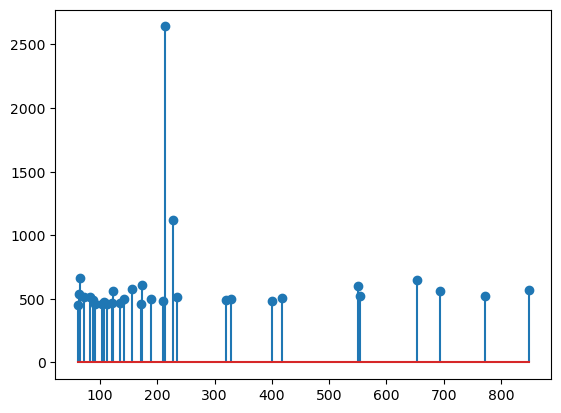

In [5]:
import pyteomics

def get_spec_mzml_pyteomics(file, scan_num):
    file_data = mzml.MzML(file)
    return(pd.DataFrame({"mz":file_data[scan_num]['m/z array'], "int":file_data[scan_num]['intensity array']}))

spec_data = get_spec_mzml_pyteomics("demo_data/180205_Poo_TruePoo_Full1.mzML", 1)
plt.stem(spec_data["mz"], spec_data["int"])

<StemContainer object of 3 artists>

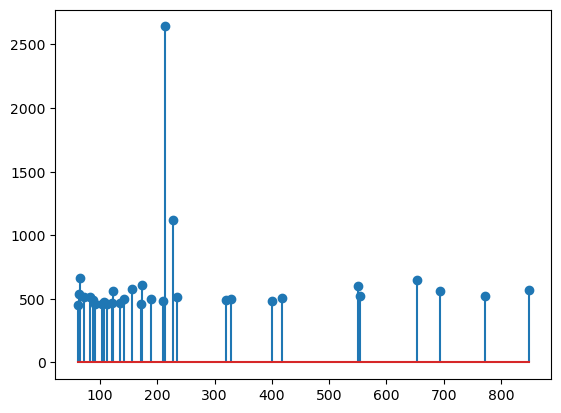

In [6]:
import pyopenms

def get_spec_mzml_pyopenms(file, scan_num):
    exp = pyopenms.MSExperiment()
    pyopenms.MzMLFile().load(file, exp)
    spec1_data = exp[scan_num].get_peaks()
    return(pd.DataFrame({"mz":spec1_data[0], "int":spec1_data[1]}))

spec_data = get_spec_mzml_pyopenms("demo_data/180205_Poo_TruePoo_Full1.mzML", 1)
plt.stem(spec_data["mz"], spec_data["int"])

[Warning] Not index found and build_index_from_scratch is False


<StemContainer object of 3 artists>

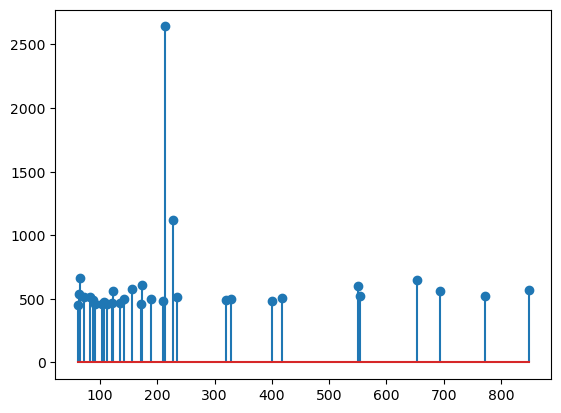

In [7]:
import pymzml

# fails for the first scan when given a non-indexed mzML even if build_index is True
# run = pymzml.run.Reader("demo_data/180205_Poo_TruePoo_Full1.mzML")
# run = pymzml.run.Reader("demo_data/180205_Poo_TruePoo_Full1.mzML", build_index_from_scratch=True)
# run = pymzml.run.Reader("demo_data/180205_Poo_TruePoo_Full1_idx.mzML")
# pymzml seems to reference their spectra by scan number
# spec1_data = run[1].peaks("raw")
# print(spec1_data)
# plt.stem(spec1_data[:,0], spec1_data[:,1])
def get_spec_mzml_pymzml(file, scan_num):
    run = pymzml.run.Reader(file)
    spec1_data = run[scan_num].peaks("raw")
    return(pd.DataFrame({"mz":spec1_data[:,0], "int":spec1_data[:,1]}))

spec_data = get_spec_mzml_pymzml("demo_data/180205_Poo_TruePoo_Full1.mzML", 3) # Referenced by scan num, not index!!!
plt.stem(spec_data["mz"], spec_data["int"])

## RT range queries
This should be a lot faster - combo of the above strategies and could be massively sped up with a precompiled index of the scan numbers and their associated RTs. However, I don't think most of these objects have that.

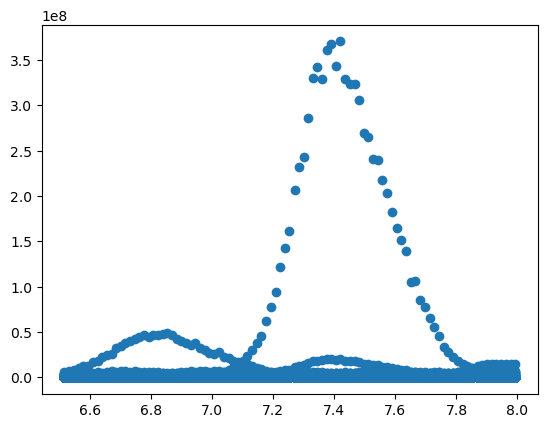

In [8]:
def get_rtrange_mzml_pyteomics(file, rtstart, rtend):
    scan_dfs = []
    for spectrum in mzml.MzML(file):
        rt_val = spectrum['scanList']['scan'][0]['scan start time']
        if(rtstart < rt_val < rtend):
            mz_vals=spectrum['m/z array']
            int_vals = spectrum['intensity array']
            df_scan = pd.DataFrame({'mz':mz_vals, 'int':int_vals, 'rt':[rt_val]*len(mz_vals)})
            scan_dfs.append(df_scan)    
    return(pd.concat(scan_dfs, ignore_index=True))

rtrange_data = get_rtrange_mzml_pyteomics('demo_data/180205_Poo_TruePoo_Full1.mzML', 6.5, 8)

plt.scatter(rtrange_data["rt"], rtrange_data["int"])
plt.show()

In [98]:

exp = pyopenms.MSExperiment()
pyopenms.MzMLFile().load('demo_data/180205_Poo_TruePoo_Full1.mzML', exp)
spec1_data = exp[0]

spec1_data.getRT()

        mz_vals, int_vals = spectrum.get_peaks()
        bet_idxs = (mz_vals>mzmin) & (mz_vals<mzmax)
    
        if(sum(bet_idxs)>0):
            df_scan = pd.DataFrame({'mz':mz_vals[bet_idxs], 'int':int_vals[bet_idxs], 'rt':[rt_val]*sum(bet_idxs)})
            scan_dfs.append(df_scan)    
    return(pd.concat(scan_dfs, ignore_index=True))


0.32410152600000003

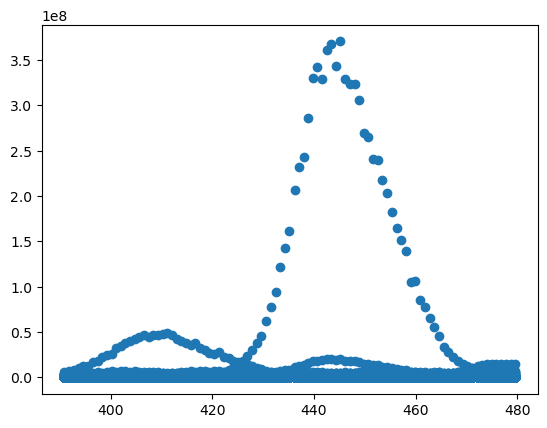

In [101]:
def get_rtrange_mzml_pyopenms(file, rtstart, rtend):
    scan_dfs = []
    for spectrum in exp:
        rt_val = spectrum.getRT()
        if(rtstart*60 < rt_val < rtend*60):
            mz_vals, int_vals = spectrum.get_peaks()
            df_scan = pd.DataFrame({'mz':mz_vals, 'int':int_vals, 'rt':[rt_val]*len(int_vals)})
            scan_dfs.append(df_scan)
    return(pd.concat(scan_dfs, ignore_index=True))

rtrange_data = get_rtrange_mzml_pyopenms('demo_data/180205_Poo_TruePoo_Full1.mzML', 6.5, 8)

plt.scatter(rtrange_data["rt"], rtrange_data["int"])
plt.show()

[Warning] Not index found and build_index_from_scratch is False
[Warning] Not index found and build_index_from_scratch is False


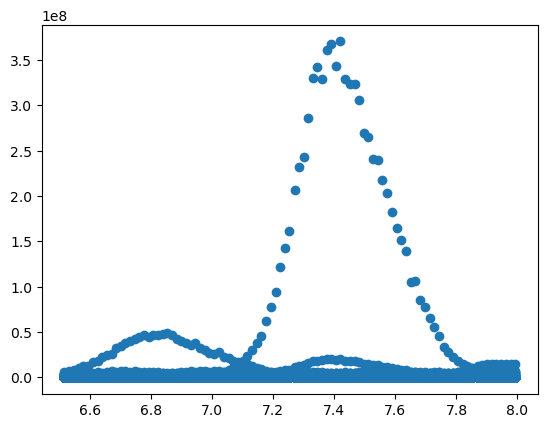

In [55]:
def get_rtrange_mzml_pymzml(file, rtstart, rtend):
    run = pymzml.run.Reader(file)  
    scan_dfs = []
    for spectrum in run:
        rt_val = spectrum.scan_time_in_minutes()
        if(rtstart<rt_val<rtend):
            df_scan = pd.DataFrame({'mz':spectrum.mz, 'int':spectrum.i, 'rt':[rt_val]*len(spectrum.i)})
            scan_dfs.append(df_scan)
    return(pd.concat(scan_dfs, ignore_index=True))

rtrange_data = get_rtrange_mzml_pymzml("demo_data/180205_Poo_TruePoo_Full1.mzML", 6.5, 8)
plt.scatter(rtrange_data["rt"], rtrange_data["int"])

## Additional pyOpenMS methods that are worth comparing against

In [80]:
"SELECT * FROM MS1 WHERE mz BETWEEN 118.06 AND 118.1"
v = exp.get_massql_df(ion_mobility=False)
# Note to self - ask them to update the docstring to reflect the correct parameter name
# Update - nevermind, seems like this just returns the entire thing into memory. Maybe a reasonable
# way to get a pure Pandas/in memory comparison

In [91]:
ms1_df, ms2_df = exp.get_massql_df(ion_mobility=False)
ms1_df.head()

,i,i_norm,i_tic_norm,mz,scan,rt,polarity
0,470.188416,0.604857,0.026702,62.010094,1,0.005402,1
1,496.883057,0.639197,0.028218,64.353043,1,0.005402,1
2,547.366028,0.704139,0.031085,68.521904,1,0.005402,1
3,445.280975,0.572816,0.025287,76.369545,1,0.005402,1
4,436.751068,0.561843,0.024803,77.480682,1,0.005402,1


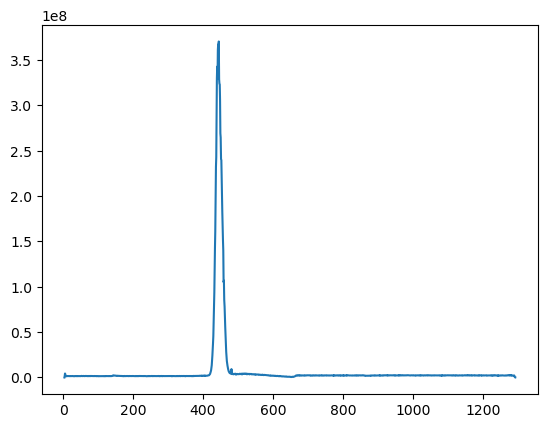

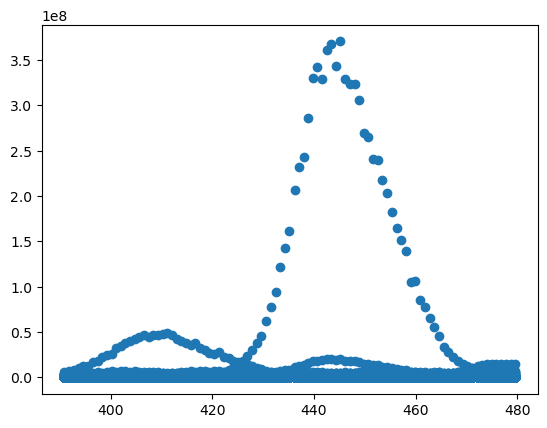

In [95]:
def get_chrom_mzml_pyopenms_2DPeak(file, mz, ppm):
    exp = pyopenms.MSExperiment()
    pyopenms.MzMLFile().load(file, exp)
    exp.updateRanges()
    mzmin, mzmax = pmppm(mz, ppm)
    chrom_data=exp.get2DPeakDataLong(min_mz=mzmin, max_mz=mzmax, min_rt=exp.getMinRT(), max_rt=exp.getMaxRT())
    return(pd.DataFrame({"rt":chrom_data[0], "mz":chrom_data[1], "int":chrom_data[2]}))
chrom_data = get_chrom_mzml_pyopenms_2DPeak("demo_data/180205_Poo_TruePoo_Full1.mzML", 118.0865, 10)
plt.plot(chrom_data["rt"], chrom_data["int"])
plt.show()

def get_rtrange_mzml_pyopenms_2DPeak(file, rtstart, rtend):
    exp = pyopenms.MSExperiment()
    pyopenms.MzMLFile().load(file, exp)
    exp.updateRanges()
    rtrange_data=exp.get2DPeakDataLong(min_mz=exp.getMinMZ(), max_mz=exp.getMaxMZ(), min_rt=rtstart, max_rt=rtend)
    return(pd.DataFrame({"rt":rtrange_data[0], "mz":rtrange_data[1], "int":rtrange_data[2]}))
rtrange_data = get_rtrange_mzml_pyopenms_2DPeak("demo_data/180205_Poo_TruePoo_Full1.mzML", 6.5*60, 8*60)
plt.scatter(rtrange_data["rt"], rtrange_data["int"])